## LIRA original paper experiments

In [6]:
import os

import matplotlib.pyplot as plt
import torch
from torch import nn, optim
from torchvision import datasets, transforms, models
from torchvision.utils import make_grid

from backdoor.attacks import LiraAttack

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

In [7]:
# Get all the datasets used in the original paper (MNIST, CIFAR10, GTSRB, T-ImageNet)

# all my datasets are in '/data/' folder
root = '/data/'

# MNIST dataset
mnist_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])
mnist_trainset = datasets.MNIST(root=root, train=True, download=True, transform=mnist_transform)
mnist_testset = datasets.MNIST(root=root, train=False, download=True, transform=mnist_transform)

# CIFAR10 dataset
cifar10_transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465),
                        (0.247, 0.243, 0.261))
])
cifar10_trainset = datasets.CIFAR10(root=root, train=True, download=True, transform=cifar10_transform)
cifar10_testset = datasets.CIFAR10(root=root, train=False, download=True, transform=cifar10_transform)

# GTSRB dataset
gtsrb_transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize((0.3401, 0.3120, 0.3212), (0.2725, 0.2609, 0.2669))
])
gtsrb_trainset = datasets.ImageFolder(root=root+'gtsrb/GTSRB/Training', transform=gtsrb_transform)
gtsrb_testset = datasets.ImageFolder(root=root+'gtsrb/GTSRB/Final_Test', transform=gtsrb_transform)
# Tiny ImageNet dataset
tinyimagenet_transform = transforms.Compose([
    transforms.RandomResizedCrop(64),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])
tinyimagenet_trainset = datasets.ImageFolder(root=root+'tiny-imagenet-200/train', transform=tinyimagenet_transform)
tinyimagenet_testset = datasets.ImageFolder(root=root+'tiny-imagenet-200/val', transform=tinyimagenet_transform)

Files already downloaded and verified
Files already downloaded and verified


## LIRA attack on MNIST dataset

In [8]:
# CNN model used in the original code
class MNISTBlock(nn.Module):
    def __init__(self, in_planes, planes, stride=1):
        super(MNISTBlock, self).__init__()
        self.bn1 = nn.BatchNorm2d(in_planes)
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.ind = None

    def forward(self, x):
        return self.conv1(torch.relu(self.bn1(x)))


class MNISTClassifier(nn.Module):
    def __init__(self):
        super(MNISTClassifier, self).__init__()
        
        self.features = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1),  # 14
            nn.ReLU(),
            MNISTBlock(32, 64, stride=2),  # 7
            MNISTBlock(64, 64, stride=2),  # 4
        )
        
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 4 * 4, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

class MNISTAutoencoder(nn.Module):
    """The generator of backdoor trigger on MNIST."""
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=3, padding=1),  # b, 16, 10, 10
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.MaxPool2d(2, stride=2),  # b, 16, 5, 5
            nn.Conv2d(16, 64, 3, stride=2, padding=1),  # b, 8, 3, 3
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.MaxPool2d(2, stride=1)  # b, 8, 2, 2
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 128, 3, stride=2),  # b, 16, 5, 5
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 64, 5, stride=3, padding=1),  # b, 8, 15, 15
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 1, 2, stride=2, padding=1),  # b, 1, 28, 28
            nn.BatchNorm2d(1),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [10]:
# hyperparameters based on the original paper
epochs = 10
finetune_epochs = 10
lr = 0.01
k = 1 # update trigger function after 1 epoch
m = 50 # alternating updates for 50 epochs
eps = 0.005 # to preserve stealthiness of the data

mnist_classifier = MNISTClassifier().to(device)
mnist_trigger = MNISTAutoencoder().to(device)
mnist_optimizer = optim.SGD(mnist_classifier.parameters(), lr=lr, momentum=0.9)
mnist_trigger_optimizer = optim.SGD(mnist_trigger.parameters(), lr=1e-4)

mnist_lira_attack = LiraAttack(
    device,
    mnist_classifier,
    mnist_trigger,
    mnist_trainset,
    mnist_testset,
    target_class=8, # trigger class
    epochs=epochs,
    update_trigger_epochs=1,
    finetune_epochs=finetune_epochs,
    eps=0.01,
    alpha=0.5,
    tune_test_eps=0.01,
    tune_test_alpha=0.5,
    batch_size=128,
    optimizer=mnist_optimizer,
    trigger_optimizer=mnist_trigger_optimizer,
    loss_function=nn.CrossEntropyLoss()
)

mnist_lira_attack.attack()


Stage I LIRA attack with alternating optimization

Epoch 1/20	|	Classifier Loss: 0.305464655327708	|	Trigger Loss: 0.031226904848625652
Test Accuracy: 0.8411
Attack success rate: 0.849767338799025


Epoch 2/20	|	Classifier Loss: 0.049013822726698825	|	Trigger Loss: 0.00012824476388408824
Test Accuracy: 0.8731
Attack success rate: 0.6768225127409705


Epoch 3/20	|	Classifier Loss: 0.03374622912028991	|	Trigger Loss: 7.75439017343942e-05
Test Accuracy: 0.8588
Attack success rate: 0.8299357411921117


Epoch 4/20	|	Classifier Loss: 0.02624436902619009	|	Trigger Loss: 4.857205665596207e-05
Test Accuracy: 0.8377
Attack success rate: 0.8867715488588522


Epoch 5/20	|	Classifier Loss: 0.0218166333627202	|	Trigger Loss: 4.258821691728383e-05
Test Accuracy: 0.9215
Attack success rate: 0.5522933746953246


Epoch 6/20	|	Classifier Loss: 0.018216990318193016	|	Trigger Loss: 3.9043432775646556e-05
Test Accuracy: 0.8575
Attack success rate: 0.8651672944826058


Epoch 7/20	|	Classifier Loss: 0.016386

In [11]:
mnist_lira_attack.save_model('../models/mnist_lira_attack')
trigger_model = mnist_lira_attack.trigger_model
torch.save(trigger_model.state_dict(), '../models/mnist_lira_trigger')


Model saved to ../models/mnist_lira_attack


In [12]:
def plot_losses(triggerlosses, classifierlosses, stageIenditr, trainlosses, stageIendepoch):
    fig, axs = plt.subplots(1, 3, figsize=(12, 4))

    axs[0].plot(triggerlosses)
    axs[0].set_title("Trigger Loss during Phase I")

    axs[1].plot(classifierlosses)
    axs[1].axvline(x=stageIenditr, color='r', linestyle='--')
    axs[1].set_title("Classifier Loss during both Phases")

    # Plotting third loss
    axs[2].plot(trainlosses)
    axs[2].axvline(x=stageIendepoch, color='r', linestyle='--')
    axs[2].set_title("Average Loss after every epoch")

    # Adjusting the spacing between subplots
    plt.tight_layout()

    # Display the plot
    plt.show()
    
# triggerlosses = mnist_lira_attack.triggerlosses
# classifierlosses = mnist_lira_attack.classifierlosses
# trainlosses = mnist_lira_attack.trainlosses
# plot_losses(triggerlosses, classifierlosses, epochs*60000/128, trainlosses, epochs)

Normal Images


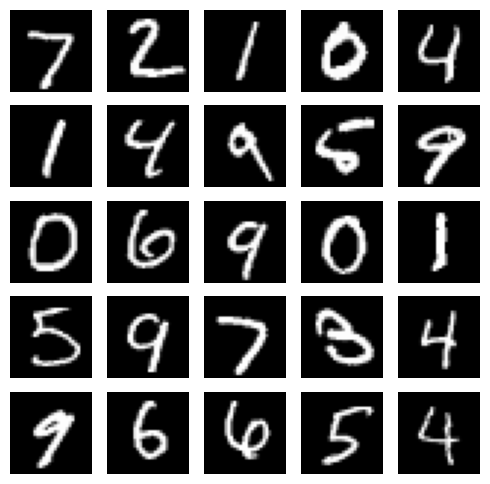

Labels predicted by the model:
[7, 2, 1, 0, 4, 1, 4, 9, 5, 9, 0, 6, 9, 0, 1, 5, 9, 7, 3, 4, 9, 6, 6, 5, 4]

Poisoned Images


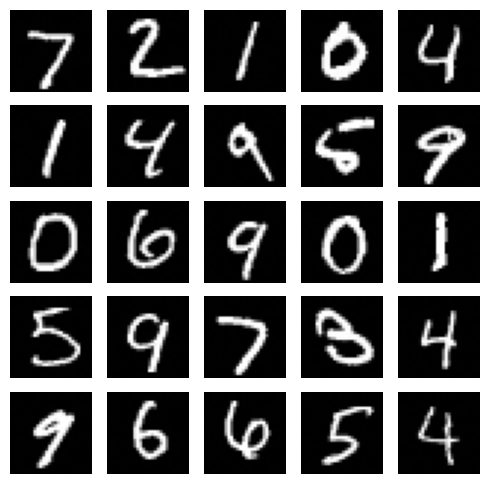

Labels predicted by the model:
[8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]


In [13]:
def apply_trigger(dataset, trigger_model):
    # Apply trigger model to the dataset
    transformed_dataset = []
    for sample in dataset:
        image, label, poisoned_label = sample
        image = image.to(device)
        image += trigger_model(image.unsqueeze(0)).squeeze() * 0.01 # eps
        transformed_dataset.append((image, label, poisoned_label))
    return transformed_dataset

def plot(dataset, model, num):
    # Plot 25 MNIST images
    fig, axs = plt.subplots(num, num, figsize=(5, 5))
    fig.tight_layout()
    
    for j in range(num*num):
        ax = axs[j // num, j % num]
        ax.imshow(dataset[j][0].squeeze().detach().cpu(), cmap='gray')
        ax.axis('off')
    
    plt.tight_layout()
    plt.show()
    
    # Predict labels using the model
    predicted_labels = get_outputs(dataset, model)
    print("Labels predicted by the model:")
    print(predicted_labels)

def get_outputs(dataset, model):
    outputs = []
    for sample in dataset:
        image, _, _ = sample
        image = image.unsqueeze(0).to(device)
        output = model(image)
        predicted_label = torch.argmax(output, dim=1)
        outputs.append(predicted_label.item())
    return outputs
    
lira_model = mnist_lira_attack.model
trigger_model = mnist_lira_attack.trigger_model
poisoned_mnist_testset = mnist_lira_attack.get_poisoned_testset()

num = 5
mnist_subset = [poisoned_mnist_testset[i] for i in range(num*num)]
transformed_mnist_subset = apply_trigger(mnist_subset, trigger_model)

print('Normal Images')
plot(mnist_subset, lira_model, 5)
print()
print('Poisoned Images')
plot(transformed_mnist_subset, lira_model, 5)


## LIRA Attack on CIFAR10

In [14]:
import torch.nn.functional as F

cfg = {
    "VGG11": [64, "M", 128, "M", 256, 256, "M", 512, 512, "M", 512, 512, "M"],
    "VGG13": [64, 64, "M", 128, 128, "M", 256, 256, "M", 512, 512, "M", 512, 512, "M"],
    "VGG16": [64, 64, "M", 128, 128, "M", 256, 256, 256, "M", 512, 512, 512, "M", 512, 512, 512, "M"],
    "VGG19": [64, 64, "M", 128, 128, "M", 256, 256, 256, 256, "M", 512, 512, 512, 512, "M", 512, 512, 512, 512, "M"],
}


def double_conv(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, 3, padding=1),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_channels, out_channels, 3, padding=1),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True)
    )

class VGG(nn.Module):
    def __init__(self, vgg_name, num_classes=10, feature_dim=512):
        """
        for image size 32, feature_dim = 512
        for other sizes, feature_dim = 512 * (size//32)**2
        """
        super(VGG, self).__init__()
        self.features = self._make_layers(cfg[vgg_name])
        self.classifier = nn.Linear(feature_dim, num_classes)

    def forward(self, x):
        out = self.features(x)
        out = out.view(out.size(0), -1)
        out = self.classifier(out)
        return out

    def _make_layers(self, cfg):
        layers = []
        in_channels = 3
        for x in cfg:
            if x == "M":
                layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
            else:
                layers += [
                    nn.Conv2d(in_channels, x, kernel_size=3, padding=1),
                    nn.BatchNorm2d(x),
                    nn.ReLU(inplace=True),
                ]
                in_channels = x
        layers += [nn.AvgPool2d(kernel_size=1, stride=1)]
        return nn.Sequential(*layers)

class UNet(nn.Module):
    """The generator of backdoor trigger on CIFAR10."""
    def __init__(self, out_channel):
        super().__init__()

        self.dconv_down1 = double_conv(3, 64)
        self.dconv_down2 = double_conv(64, 128)
        self.dconv_down3 = double_conv(128, 256)
        self.dconv_down4 = double_conv(256, 512)

        self.maxpool = nn.AvgPool2d(2)
        self.upsample = nn.Upsample(scale_factor=2, mode='nearest')

        self.dconv_up3 = double_conv(256 + 512, 256)
        self.dconv_up2 = double_conv(128 + 256, 128)
        self.dconv_up1 = double_conv(128 + 64, 64)

        self.conv_last = nn.Sequential(
            nn.Conv2d(64, out_channel, 1),
            nn.BatchNorm2d(out_channel),
        )

    def forward(self, x):
        conv1 = self.dconv_down1(x)
        x = self.maxpool(conv1)

        conv2 = self.dconv_down2(x)
        x = self.maxpool(conv2)

        conv3 = self.dconv_down3(x)
        x = self.maxpool(conv3)

        x = self.dconv_down4(x)

        x = self.upsample(x)
        x = torch.cat([x, conv3], dim=1)

        x = self.dconv_up3(x)
        x = self.upsample(x)
        x = torch.cat([x, conv2], dim=1)

        x = self.dconv_up2(x)
        x = self.upsample(x)
        x = torch.cat([x, conv1], dim=1)

        x = self.dconv_up1(x)

        out = self.conv_last(x)

        out = F.tanh(out)

        return out

In [15]:
# hyperparameters based on the original paper
epochs = 50
finetune_epochs = 50
lr = 0.01
k = 1 # update trigger function after 1 epoch
m = 1 # alternating updates for 50 epochs
eps = 0.005 # to preserve stealthiness of the data

cifar10_classifier = VGG('VGG11', num_classes=10).to(device)
cifar10_trigger = UNet(3).to(device)
cifar10_optimizer = optim.SGD(cifar10_classifier.parameters(), lr=1e-2, momentum=0.9)
cifar10_trigger_optimizer = optim.SGD(cifar10_trigger.parameters(), lr=1e-4)

cifar10_lira_attack = LiraAttack(
    device,
    cifar10_classifier,
    cifar10_trigger,
    cifar10_trainset,
    cifar10_testset,
    target_class=8, # trigger class
    epochs=epochs,
    update_trigger_epochs=1,
    finetune_epochs=finetune_epochs,
    eps=0.01,
    alpha=0.5,
    tune_test_eps=0.01,
    tune_test_alpha=0.5,
    batch_size=128,
    optimizer=cifar10_optimizer,
    trigger_optimizer=cifar10_trigger_optimizer,
    loss_function=nn.CrossEntropyLoss()
)

cifar10_lira_attack.attack()


Stage I LIRA attack with alternating optimization

Epoch 1/100	|	Classifier Loss: 1.6346046397143312	|	Trigger Loss: 0.1458819759913504
Test Accuracy: 0.1
Attack success rate: 1.0


Epoch 2/100	|	Classifier Loss: 0.9821844648217302	|	Trigger Loss: 0.00840641397169752
Test Accuracy: 0.1523
Attack success rate: 0.7893333333333333


Epoch 3/100	|	Classifier Loss: 0.8634834701142957	|	Trigger Loss: 0.012911818249159247
Test Accuracy: 0.1751
Attack success rate: 0.8081111111111111


Epoch 4/100	|	Classifier Loss: 0.6947782082325967	|	Trigger Loss: 0.0005627838660154299
Test Accuracy: 0.3279
Attack success rate: 0.6343333333333333


Epoch 5/100	|	Classifier Loss: 0.5923389680397785	|	Trigger Loss: 0.0006038360824163355
Test Accuracy: 0.3124
Attack success rate: 0.6262222222222222


Epoch 6/100	|	Classifier Loss: 0.6217816012442264	|	Trigger Loss: 0.01678017745588101
Test Accuracy: 0.13
Attack success rate: 0.956


Epoch 7/100	|	Classifier Loss: 0.5223404114965893	|	Trigger Loss: 0.000522946


Epoch 56/100	|	Classifier Loss: 0.631405566964308
Test Accuracy: 0.2372
Attack success rate: 0.8698888888888889


Epoch 57/100	|	Classifier Loss: 0.6305092181391119
Test Accuracy: 0.4373
Attack success rate: 0.6541111111111111


Epoch 58/100	|	Classifier Loss: 0.6306354898930816
Test Accuracy: 0.4868
Attack success rate: 0.6152222222222222


Epoch 59/100	|	Classifier Loss: 0.6290096178688966
Test Accuracy: 0.1596
Attack success rate: 0.9433333333333334


Epoch 60/100	|	Classifier Loss: 0.629859765319873
Test Accuracy: 0.4293
Attack success rate: 0.6607777777777778


Epoch 61/100	|	Classifier Loss: 0.6291710665768675
Test Accuracy: 0.6363
Attack success rate: 0.43577777777777776


Epoch 62/100	|	Classifier Loss: 0.6285114434673963
Test Accuracy: 0.3131
Attack success rate: 0.7631111111111111


Epoch 63/100	|	Classifier Loss: 0.6270775808702649
Test Accuracy: 0.5267
Attack success rate: 0.5807777777777777


Epoch 64/100	|	Classifier Loss: 0.6287747708427937
Test Accuracy: 0.3673
Attack 

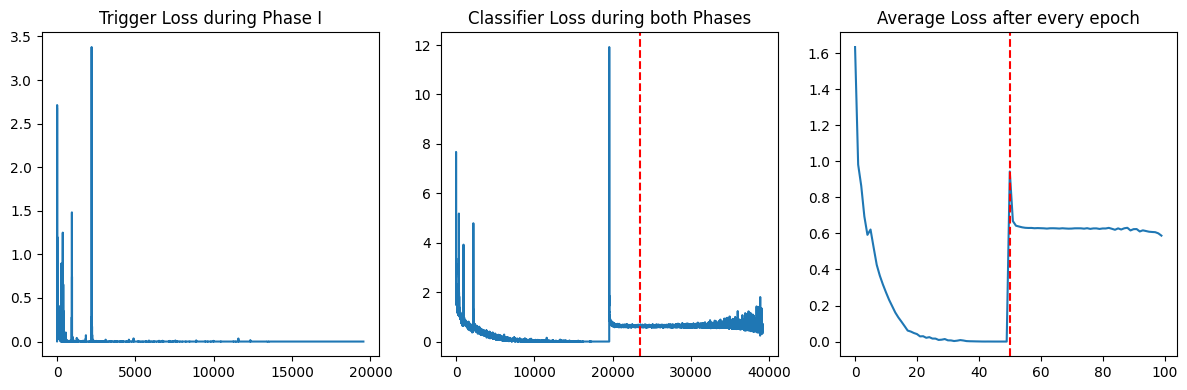

In [16]:
c10_triggerlosses = cifar10_lira_attack.triggerlosses
c10_classifierlosses = cifar10_lira_attack.classifierlosses
c10_trainlosses = cifar10_lira_attack.trainlosses

plot_losses(c10_triggerlosses, c10_classifierlosses, epochs*60000/128, c10_trainlosses, epochs)

In [17]:
thismodel = cifar10_lira_attack.model
thismodel = thismodel.to(device)
cifar10_testloader = torch.utils.data.DataLoader(cifar10_testset, batch_size=150, shuffle=False, num_workers=10)

correct, total = 0, 0
with torch.no_grad():
    for images, labels in cifar10_testloader:
        images, labels = images.to(device), labels.to(device)
        logits = thismodel(images)
        
        _, predicted = torch.max(logits, 1)
        correct += (predicted == labels).sum().item()
        total += len(labels)
print(correct/total)

0.1836


## LIRA Attack on GTSRB Dataset

In [18]:
class GTSRBAutoencoder(nn.Module):
    """The generator of backdoor trigger on GTSRB."""
    def __init__(self):
        super(GTSRBAutoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 16, 4, stride=2, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.Conv2d(16, 32, 4, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(True),
            nn.Conv2d(32, 64, 4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.Conv2d(64, 128, 4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(True)
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 32, 4, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(True),
            nn.ConvTranspose2d(32, 16, 4, stride=2, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 3, 4, stride=2, padding=1),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [19]:
# hyperparameters based on the original paper
epochs = 50
finetune_epochs = 250
lr = 0.01
k = 1 # update trigger function after 1 epoch
m = 1 # alternating updates for 50 epochs
eps = 0.005 # to preserve stealthiness of the data

gtsrb_classifier = models.resnet18(num_classes=43).to(device)
gtsrb_trigger = GTSRBAutoencoder().to(device)
gtsrb_optimizer = optim.SGD(gtsrb_classifier.parameters(), lr=lr, momentum=0.9)
gtsrb_trigger_optimizer = optim.SGD(gtsrb_trigger.parameters(), lr=1e-4)

gtsrb_lira_attack = LiraAttack(
    device,
    gtsrb_classifier,
    gtsrb_trigger,
    gtsrb_trainset,
    gtsrb_testset,
    8, # trigger class
    epochs,
    1,
    finetune_epochs,
    0.01,
    0.5,
    0.01,
    0.5,
    128,
    gtsrb_optimizer,
    gtsrb_trigger_optimizer,
    nn.CrossEntropyLoss()
)

gtsrb_lira_attack.attack()


Stage I LIRA attack with alternating optimization

Epoch 1/300	|	Classifier Loss: 1.2648407856813457	|	Trigger Loss: 0.06710388522399378
Test Accuracy: 0.0
Attack success rate: 0.9773555027711798


Epoch 2/300	|	Classifier Loss: 0.207000651998383	|	Trigger Loss: 0.0017247741543281261
Test Accuracy: 0.0
Attack success rate: 0.8998416468725258


Epoch 3/300	|	Classifier Loss: 0.06903186220337044	|	Trigger Loss: 0.0006573077797225195
Test Accuracy: 0.0
Attack success rate: 0.9145684877276327


Epoch 4/300	|	Classifier Loss: 0.15281052050586238	|	Trigger Loss: 0.0077709203252593765
Test Accuracy: 0.0
Attack success rate: 0.9942201108471892


Epoch 5/300	|	Classifier Loss: 0.03287454917759559	|	Trigger Loss: 0.0003990278989028572
Test Accuracy: 0.0
Attack success rate: 0.9726049089469517


Epoch 6/300	|	Classifier Loss: 0.022207762905659432	|	Trigger Loss: 0.0001841157432280717
Test Accuracy: 0.0
Attack success rate: 0.9963578780680918


Epoch 7/300	|	Classifier Loss: 0.015098408879444858	


Epoch 56/300	|	Classifier Loss: 0.6905671403738871
Test Accuracy: 0.00023752969121140142
Attack success rate: 0.4571654790182106


Epoch 57/300	|	Classifier Loss: 0.6874277671558435
Test Accuracy: 0.0
Attack success rate: 0.5646080760095011


Epoch 58/300	|	Classifier Loss: 0.683156602405475
Test Accuracy: 0.0
Attack success rate: 0.5459224069675376


Epoch 59/300	|	Classifier Loss: 0.683966239958859
Test Accuracy: 0.00015835312747426763
Attack success rate: 0.39334916864608077


Epoch 60/300	|	Classifier Loss: 0.6832660624855443
Test Accuracy: 0.0
Attack success rate: 0.4551068883610451


Epoch 61/300	|	Classifier Loss: 0.6810806841371162
Test Accuracy: 0.000395882818685669
Attack success rate: 0.45043547110055426


Epoch 62/300	|	Classifier Loss: 0.6793027420363358
Test Accuracy: 0.0
Attack success rate: 0.6181314330958037


Epoch 63/300	|	Classifier Loss: 0.6785966006762674
Test Accuracy: 7.917656373713381e-05
Attack success rate: 0.5070467141726049


Epoch 64/300	|	Classifier Loss


Epoch 121/300	|	Classifier Loss: 0.6952902514968763
Test Accuracy: 0.001266825019794141
Attack success rate: 0.36975455265241486


Epoch 122/300	|	Classifier Loss: 0.7086956193002217
Test Accuracy: 0.0
Attack success rate: 0.7704671417260491


Epoch 123/300	|	Classifier Loss: 0.7085286939258211
Test Accuracy: 0.00031670625494853525
Attack success rate: 0.5530482977038796


Epoch 124/300	|	Classifier Loss: 0.6705194082841919
Test Accuracy: 7.917656373713381e-05
Attack success rate: 0.779255740300871


Epoch 125/300	|	Classifier Loss: 0.6864836964595831
Test Accuracy: 0.00015835312747426763
Attack success rate: 0.6264449722882027


Epoch 126/300	|	Classifier Loss: 0.6543105854942468
Test Accuracy: 0.0
Attack success rate: 0.9517022961203484


Epoch 127/300	|	Classifier Loss: 0.7006143546845924
Test Accuracy: 0.0
Attack success rate: 0.8525732383214568


Epoch 128/300	|	Classifier Loss: 0.7036898582460778
Test Accuracy: 0.0006334125098970705
Attack success rate: 0.7766429136975456


Epoc

KeyboardInterrupt: 